# NMA CN Project

- **Pod**: careful wolfs ⚠️🐺
- **Question**: is there a difference in neural activation at the cell level following stimulus presentation in the active vs passive conditions?

## Imports

In [1]:
# Only for Colab
# !python -m pip install --upgrade pip
# !pip install allensdk

In [2]:
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

/home/seungjaeryanlee/anaconda3/envs/nma-cn/lib/python3.8/site-packages/allensdk/brain_observatory/session_api_utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Setup AllenSDK

In [3]:
!mkdir -p allensdk_storage
DATA_STORAGE_DIRECTORY = Path("./allensdk_storage")

In [4]:
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=DATA_STORAGE_DIRECTORY)

In [5]:
experiments_df = cache.get_ophys_experiment_table()

## Filter `experiments_df`

In [6]:
PROJECT_CODE = "VisualBehavior"
FULL_GENOTYPE = "Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt"

In [7]:
filtered_experiments_df = experiments_df.query("project_code == @PROJECT_CODE") \
                                        .query("full_genotype == @FULL_GENOTYPE")

## General Helper Functions
- `get_cell_specimen_ids(experiment)`
- `get_indices_in_interval(experiment, start, end)`
- `get_timestamps_in_interval(experiment, start, end)`
- `get_cell_dff_in_interval(experiment, cell_specimen_id, start, end)`

In [8]:
def get_cell_specimen_ids(experiment):
    """
    Get all the cell specimen ids recorded in the experiment.
    """
    return experiment.dff_traces.index

In [9]:
def get_indices_in_interval(experiment, start, end):
    """
    Get all indices of timestamps where dF/F trace was recorded during a specified interval.
    """
    indices = np.argwhere((experiment.ophys_timestamps >= start) & (experiment.ophys_timestamps <= end))[:, 0]
    return indices

In [10]:
def get_timestamps_in_interval(experiment, start, end):
    """
    Get all timestamps when dF/F trace was recorded during a specified interval.
    """
    indices = get_indices_in_interval(experiment, start, end)
    return experiment.ophys_timestamps[indices]

In [11]:
def get_cell_dff_in_interval(experiment, cell_specimen_id, start, end):
    """
    Get dF/F trace for one cell during a specified interval.
    """
    indices = get_indices_in_interval(experiment, start, end)
    return experiment.dff_traces.loc[cell_specimen_id]["dff"][indices[0]:indices[-1]+1]

## Cell Selection

### Cell Selection Helper Functions
- `get_image_names(experiment)`
- `get_image_start_times(experiment, image_name)`
- `score_and_sort_cells(experiment, image_name, t_before, t_after, n_before, n_after)`
- `plot_score_histogram(scores)`
- `plot_dff(experiment, image_name, selected_cell_specimen_ids, t_before, t_after, n_before, n_after)`

In [12]:
def get_image_names(experiment):
    return experiment.stimulus_presentations["image_name"].unique()

In [13]:
def get_image_start_times(experiment, image_name):
    return active_experiment.stimulus_presentations.query("image_name == @image_name")["start_time"]

In [14]:
def score_and_sort_cells(experiment, image_name, t_before, t_after, n_before, n_after):
    cell_specimen_ids = get_cell_specimen_ids(active_experiment)
    dff_matrix = np.vstack(experiment.dff_traces.dff.values)
    stimulus_for_image_start_times = get_image_start_times(experiment, image_name)

    # Compute score for each cell
    zscored_for_image_lst = []
    for stimulus_start_time in tqdm(stimulus_for_image_start_times):
        before_indices = get_indices_in_interval(
            active_experiment,
            start=stimulus_start_time - t_before,
            end=stimulus_start_time,
        )[-n_before:]
        after_indices = get_indices_in_interval(
            active_experiment,
            start=stimulus_start_time,
            end=stimulus_start_time + t_after,
        )[:n_after]

        before_mean_dff = np.mean(dff_matrix[:, before_indices], axis=1)
        before_std_dff = np.std(dff_matrix[:, before_indices], axis=1)

        # zscored = ( after stimulus onset dff - mean(before stimulus onset dff) ) / std(before stimulus onset dff)
        after_zscored = (dff_matrix[:, after_indices] - np.tile(before_mean_dff, (len(after_indices), 1)).T) / np.tile(before_std_dff, (len(after_indices), 1)).T
        zscored_for_image_lst.append(after_zscored)
    zscored_for_image = np.stack(zscored_for_image_lst, axis=1)
    zscored_mean_over_presentations = np.max(zscored_for_image, axis=2)
    max_zscored = np.mean(zscored_mean_over_presentations, axis=1)

    sorted_cells_and_scores = sorted(zip(cell_specimen_ids, max_zscored), key=lambda x: x[1], reverse=True)
    sorted_cell_specimen_ids = [cns[0] for cns in sorted_cells_and_scores]
    sorted_scores = [cns[1] for cns in sorted_cells_and_scores]

    return sorted_cell_specimen_ids, sorted_scores

In [15]:
def plot_score_histogram(scores):
    fig, ax = plt.subplots(figsize=(8, 6))

    ax = sns.histplot(scores)
    ax.set_title("Distribution of scores across cells")

    fig.show()

In [16]:
def plot_dff(experiment, image_name, selected_cell_specimen_ids, t_before, t_after, n_before, n_after):
    cell_specimen_ids = get_cell_specimen_ids(active_experiment)
    stimulus_for_image_start_times = get_image_start_times(experiment, image_name)

    # Average dff across all stimulus presentations
    dff_matrix = np.vstack(experiment.dff_traces.dff.values)
    dff_traces_lst = []
    for stimulus_start_time in stimulus_for_image_start_times:
        before_indices = get_indices_in_interval(
            experiment,
            start=stimulus_start_time - t_before,
            end=stimulus_start_time,
        )[-n_before:]
        after_indices = get_indices_in_interval(
            experiment,
            start=stimulus_start_time,
            end=stimulus_start_time + t_after,
        )[:n_after]
        dff_traces_lst.append(np.hstack((dff_matrix[:, before_indices], dff_matrix[:, after_indices])))
    dff_traces = np.stack(dff_traces_lst, axis=1)
    dff_traces_mean, dff_traces_std = np.mean(dff_traces, axis=1), np.std(dff_traces, axis=1)

    # Choose dff traces for given cell specimen ids
    indices = [np.argwhere(cell_specimen_ids == i)[0][0] for i in selected_cell_specimen_ids]
    top_k_dff_traces = dff_traces_mean[indices]
    top_k_dff_std = dff_traces_std[indices]

    # Plot dff traces
    fig, ax = plt.subplots(figsize=(8, 6))
    xs = np.arange(top_k_dff_traces.shape[1])
    ax.plot(xs, top_k_dff_traces.T)
    for i in range(len(indices)):
        ax.fill_between(
            xs,
            top_k_dff_traces[i].T - top_k_dff_std[i].T,
            top_k_dff_traces[i].T + top_k_dff_std[i].T,
            alpha=0.1,
        )
        ax.axvline(n_before-0.5, color="pink")
        ax.set_title(f"Cell dFF traces for {image_name} in experiment {active_experiment.metadata['ophys_experiment_id']}\nt=(-{t_before},{t_after}), n=(-{n_before},{n_after})")
        fig.legend(selected_cell_specimen_ids)

    fig.show()

### Experiments

In [17]:
filtered_experiments_df["mouse_id"].unique()

array([450471, 459777, 459773, 447663, 445270, 403491, 456917, 456916,
       425493, 431023, 436662, 440298, 431252, 453913, 412366, 425496,
       445002])

In [18]:
MOUSE_ID = 450471

In [19]:
filtered_experiments_df.query("mouse_id == @MOUSE_ID")["session_type"]

ophys_experiment_id
871155338            OPHYS_1_images_A
872433717            OPHYS_1_images_A
873156540            OPHYS_1_images_A
873972085            OPHYS_1_images_A
877022592    OPHYS_2_images_A_passive
878363088            OPHYS_3_images_A
879331157            OPHYS_4_images_B
880374622    OPHYS_5_images_B_passive
880961028            OPHYS_6_images_B
Name: session_type, dtype: object

In [20]:
active_experiment = cache.get_behavior_ophys_experiment(871155338)

In [21]:
get_image_names(active_experiment)

array(['im065', 'omitted', 'im063', 'im061', 'im077', 'im085', 'im066',
       'im062', 'im069'], dtype=object)

---

In [22]:
sorted_cell_specimen_ids, sorted_scores = score_and_sort_cells(active_experiment, "im085", t_before=0.25, t_after=0.25, n_before=7, n_after=7)

100%|██████████| 644/644 [00:00<00:00, 941.62it/s] 


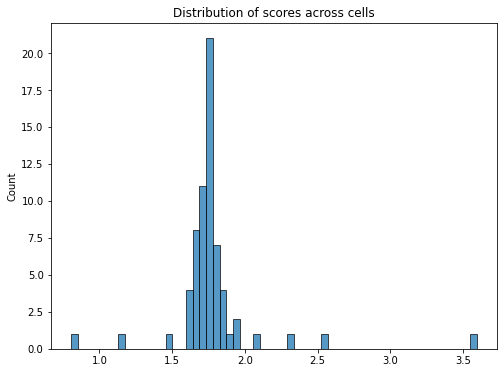

In [23]:
plot_score_histogram(sorted_scores)

In [24]:
list(zip(sorted_cell_specimen_ids, sorted_scores))[:5]

[(1086522347, 3.5926475626599217),
 (1086548183, 2.5300113049374775),
 (1086524443, 2.30302956655718),
 (1086527587, 2.0944942408973737),
 (1086526507, 1.9417895975918296)]

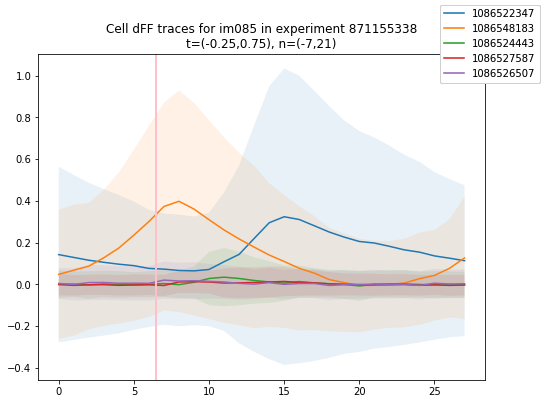

In [25]:
plot_dff(active_experiment, "im085", sorted_cell_specimen_ids[:5], t_before=0.25, t_after=0.75, n_before=7, n_after=21)